# **Simple Linear Regression (SLR)**

In this Jupyter Notebook, we perform linear regression analysis on two datasets:
1. **Galton's Height Data**: We explore the relationship between parent and child heights using simple linear regression.
2. **NBA Player Statistics (2018-19 Season)**: We predict the average points per game (`PTS`) of NBA players based on their average assists per game (`AST`) and average 3-point field goals attempted per game (`3PA`) using multiple linear regression.

We will define helper functions for regression analysis, visualize data and regression models, compute and interpret regression coefficients, RMSE, and R-squared values, as well as visualize the loss surface for the linear regression model.

---

## **1. Import Libraries**

We import the necessary libraries for data manipulation, visualization, and statistical analysis.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "notebook"
import warnings
warnings.filterwarnings('ignore')

***

## **2. Defining Helper Functions**

We define helper functions to compute standard units and the Pearson correlation coefficient.

In [2]:
# Define functions for regression analysis
def standard_units(x):
    """Convert a sequence of numbers to standard units."""
    return (x - np.mean(x)) / np.std(x)

def correlation(x, y):
    """Compute the Pearson correlation coefficient between two arrays."""
    return np.mean(standard_units(x) * standard_units(y))

***

## **3. Loading Galton's Height Data**

We load the dataset containing parent and child heights collected by Francis Galton.

In [3]:
# Load Galton's height data
df = pd.read_csv('../data/galton.csv')
df.head()

Unnamed: 0  parent  child
0           1    70.5   61.7
1           2    68.5   61.7
2           3    65.5   61.7
3           4    64.5   61.7
4           5    64.0   61.7

***

## **4. Visualizing Parent and Child Heights**

We visualize the relationship between parent and child heights.

In [4]:
# Visualize the relationship between parent and child heights
fig = px.scatter(df, x='parent', y='child', title='Parent vs Child Heights')
fig.show()

### **4.1 ~ Addressing Overplotting**

Since both 'parent' and 'child' heights occur at fixed positions, we add random noise to avoid overplotting.

In [5]:
# Add random noise to parent and child heights to avoid overplotting
np.random.seed(0)  # for reproducibility
df['parent'] = df['parent'] + np.random.randn(len(df)) / 2
df['child'] = df['child'] + np.random.randn(len(df)) / 2

# Visualize the data again after adding noise
fig = px.scatter(df, x='parent', y='child', title='Parent vs Child Heights (with noise)')
fig.show()

***

## **5. Computing Correlation**

We compute the correlation between parent and child heights using our custom function and built-in functions.

In [6]:
# Compute correlation using custom function
corr_custom = correlation(df['parent'], df['child'])
print(f"Correlation (custom function): {corr_custom}")

# Compute correlation using NumPy's corrcoef
corr_numpy = np.corrcoef(df['parent'], df['child'])[0, 1]
print(f"Correlation (NumPy): {corr_numpy}")

# Compute correlation using Pandas
corr_pandas = df['parent'].corr(df['child'])
print(f"Correlation (Pandas): {corr_pandas}")

Correlation (custom function): 0.42369313298196587
Correlation (NumPy): 0.42369313298196565
Correlation (Pandas): 0.42369313298196565


All methods yield the same result.

***

## **6. Computing Average Child Height for Given Parent Height**

We aim to compute the average child height for a given parent height by binning the 'parent' heights.

In [7]:
# Find the average child height for parent heights near 68
x = 68
average_child_height = df.query(f'parent < {x+0.5} and parent > {x-0.5}')['child'].mean()
print(f"Average child height for parent height near {x}: {average_child_height}")

Average child height for parent height near 68: 67.80349227141183


### **6.1 ~ Defining a Function for Averaging**

We define a function to compute the average child height for any given parent height.

In [8]:
# Define function to compute average child height for given parent height
def find_avg(x):
    """Return the average child height for parent heights within 0.5 units of x."""
    return df.query(f'parent < {x+0.5} and parent > {x-0.5}')['child'].mean()

### **6.2. ~ Applying the Function to the Dataset**

We apply the function to all parent heights to get predicted child heights.

In [9]:
# Apply the function to all parent heights to get predicted child heights
df['child_predicted'] = df['parent'].apply(find_avg)

### **6.3 ~ Visualizing Actual vs Predicted Child Heights**

We compare the actual child heights with the predicted averages based on parent heights.

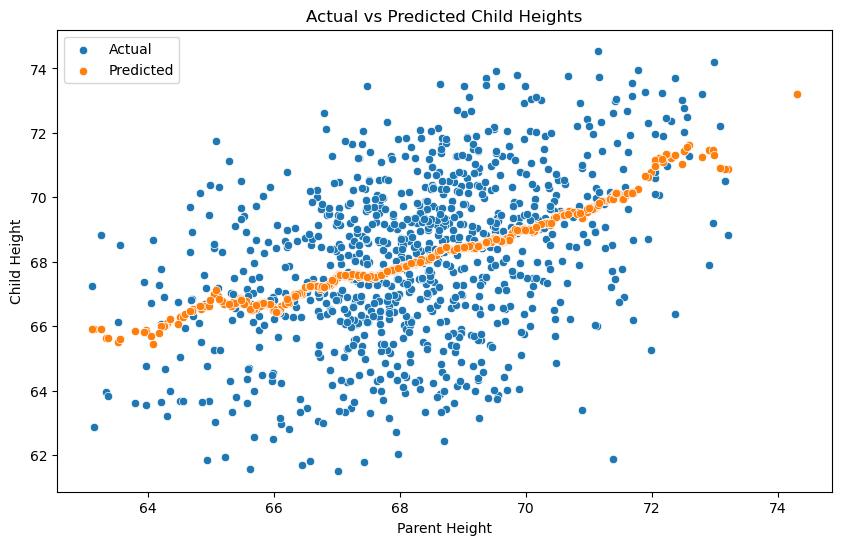

In [10]:
# Visualize actual vs predicted child heights
plt.figure(figsize=(10, 6))
sns.scatterplot(x='parent', y='child', data=df, label='Actual')
sns.scatterplot(x='parent', y='child_predicted', data=df, label='Predicted')
plt.title('Actual vs Predicted Child Heights')
plt.xlabel('Parent Height')
plt.ylabel('Child Height')
plt.legend()
plt.show()

***

## **7. Simple Linear Regression**

We compute the optimized slope and intercept for a linear model predicting child height from parent height.

In [11]:
# Define functions to compute slope and intercept
def slope(x, y):
    """Compute the slope for linear regression."""
    return correlation(x, y) * np.std(y) / np.std(x)
    
def intercept(x, y):
    """Compute the intercept for linear regression."""
    return np.mean(y) - slope(x, y) * np.mean(x)
    
# Compute slope and intercept for the linear model
bhat = slope(df['parent'], df['child'])
ahat = intercept(df['parent'], df['child'])
print("Linear Model: y = {:.2f} + {:.2f} * x".format(ahat, bhat))

Linear Model: y = 28.60 + 0.58 * x


### **7.1 ~ Visualizing Linear Regression Model**

We plot the linear regression model alongside the actual data and the binned averages.

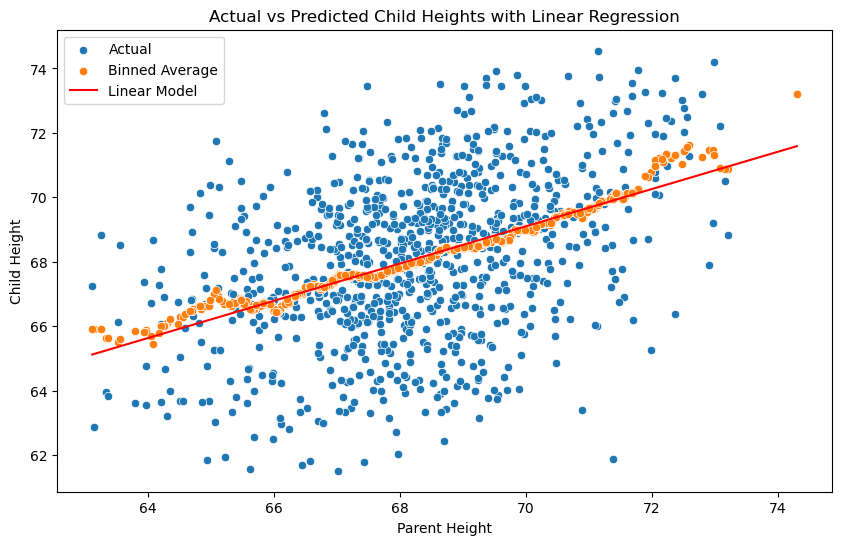

In [12]:
# Visualize the linear model predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='parent', y='child', data=df, label='Actual')
sns.scatterplot(x='parent', y='child_predicted', data=df, label='Binned Average')
sns.lineplot(x=df['parent'], y=ahat + bhat * df['parent'], label='Linear Model', color='red')
plt.title('Actual vs Predicted Child Heights with Linear Regression')
plt.xlabel('Parent Height')
plt.ylabel('Child Height')
plt.legend()
plt.show()

### **7.2 ~ Visualizing Loss Surface**

We visualize the Mean Squared Error (MSE) as a function of the model parameters to see how the MSE changes with different choices of slope and intercept.

In [13]:
# Define Mean Squared Error function
def mse(y, yhat):
    """Compute Mean Squared Error between actual and predicted values."""
    return np.mean((y - yhat) ** 2)

# Function to compute MSE for a given model parameters (a, b)
def mse_for_height_model(t):
    a, b = t
    yhat = a + b * df['parent']
    return mse(df['child'], yhat)

# Generate grid of parameter values
num_points = 200  # Increase for better resolution, but it will run more slowly.
uvalues = np.linspace(20, 32, num_points)
vvalues = np.linspace(-1, 3, num_points)
u, v = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(), v.flatten()))

# Compute MSE for each parameter combination
MSE = np.array([mse_for_height_model(t) for t in thetas.T])

# Create surface plot
loss_surface = go.Surface(x=u, y=v, z=np.reshape(MSE, u.shape), colorscale='Viridis', name='Loss Surface')

# Mark the optimal point
opt_point = go.Scatter3d(x=[ahat], y=[bhat], z=[mse_for_height_model((ahat, bhat))],
                         mode='markers', name='Optimal Parameters',
                         marker=dict(size=10, color='red'))

# Plot the loss surface and optimal point
fig = go.Figure(data=[loss_surface, opt_point])
fig.update_layout(scene=dict(
    xaxis_title="Intercept (θ₀)",
    yaxis_title="Slope (θ₁)",
    zaxis_title="MSE"),
    title='Loss Surface for Linear Regression Model')
fig.show()

As you can see, our choice of $\hat{a}, \hat{b}$ minimizes the mean squared error. They exist at the minimum value of the loss surface.

***

## **8. Multiple Linear Regression**

We now load a new dataset containing NBA player statistics from the 2018-19 season. Our goal is to predict the number of points per game (`PTS`) using two independent variables:

- `AST`: Average assists per game.
- `3PA`: Average 3-point field goals attempted per game.

In [14]:
# Load NBA player statistics dataset
nba = pd.read_csv('../data/nba18-19.csv')
nba.head()

Rk                  Player Pos  Age   Tm   G  GS    MP   FG   FGA  ...  \
0   1  Álex Abrines\abrinal01  SG   25  OKC  31   2  19.0  1.8   5.1  ...   
1   2      Quincy Acy\acyqu01  PF   28  PHO  10   0  12.3  0.4   1.8  ...   
2   3  Jaylen Adams\adamsja01  PG   22  ATL  34   1  12.6  1.1   3.2  ...   
3   4  Steven Adams\adamsst01   C   25  OKC  80  80  33.4  6.0  10.1  ...   
4   5   Bam Adebayo\adebaba01   C   21  MIA  82  28  23.3  3.4   5.9  ...   

     FT%  ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
0  0.923  0.2  1.4  1.5  0.6  0.5  0.2  0.5  1.7   5.3  
1  0.700  0.3  2.2  2.5  0.8  0.1  0.4  0.4  2.4   1.7  
2  0.778  0.3  1.4  1.8  1.9  0.4  0.1  0.8  1.3   3.2  
3  0.500  4.9  4.6  9.5  1.6  1.5  1.0  1.7  2.6  13.9  
4  0.735  2.0  5.3  7.3  2.2  0.9  0.8  1.5  2.5   8.9  

[5 rows x 30 columns]

### **8.1 ~ Exploring the Data**

We look at the relevant columns: `AST`, `3PA`, and `PTS`.

In [15]:
# View relevant columns
nba_subset = nba[['AST', '3PA', 'PTS']]
nba_subset.head()

AST  3PA   PTS
0  0.6  4.1   5.3
1  0.8  1.5   1.7
2  1.9  2.2   3.2
3  1.6  0.0  13.9
4  2.2  0.2   8.9

### **8.2 ~ Simple Linear Regression with AST**

First, we explore the relationship between assists per game and points per game.

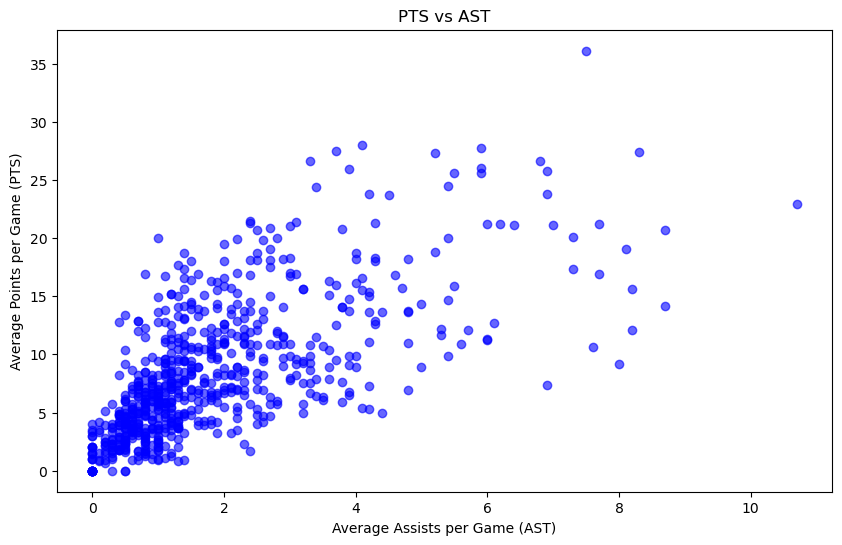

In [16]:
# Visualize the relationship between AST and PTS
plt.figure(figsize=(10, 6))
plt.scatter(nba['AST'], nba['PTS'], color='blue', alpha=0.6)
plt.xlabel('Average Assists per Game (AST)')
plt.ylabel('Average Points per Game (PTS)')
plt.title('PTS vs AST')
plt.show()

In [17]:
# Compute correlation between AST and PTS
r_nba = correlation(nba['AST'], nba['PTS'])
print(f"Correlation between AST and PTS: {r_nba}")

Correlation between AST and PTS: 0.6760218567449272


In [18]:
# Compute slope and intercept for linear model
bhat_nba = slope(nba['AST'], nba['PTS'])
ahat_nba = intercept(nba['AST'], nba['PTS'])
print("Predicted PTS = {:.2f} + {:.2f} * AST".format(ahat_nba, bhat_nba))

Predicted PTS = 3.98 + 2.40 * AST


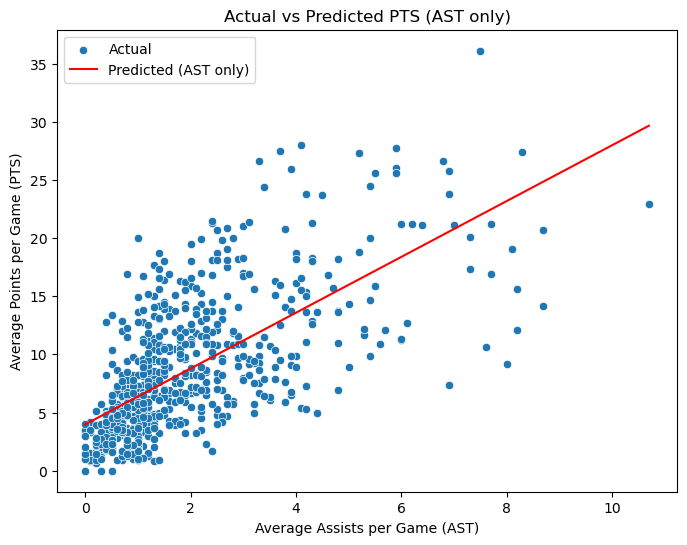

In [19]:
# Compute predicted PTS using AST only
pred_ast_only = ahat_nba + bhat_nba * nba['AST']

# Plot actual vs predicted PTS
plt.figure(figsize=(8, 6))
sns.scatterplot(x=nba['AST'], y=nba['PTS'], label='Actual')
sns.lineplot(x=nba['AST'], y=pred_ast_only, color='red', label='Predicted (AST only)')
plt.xlabel('Average Assists per Game (AST)')
plt.ylabel('Average Points per Game (PTS)')
plt.title('Actual vs Predicted PTS (AST only)')
plt.legend()
plt.show()

In [20]:
# Define RMSE function
def rmse(y, yhat):
    """Compute Root Mean Squared Error."""
    return np.sqrt(mse(y, yhat))

# Compute RMSE for AST only model
rmse_ast_only = rmse(nba['PTS'], pred_ast_only)
print(f"RMSE (AST only model): {rmse_ast_only}")

RMSE (AST only model): 4.291659114148544


### **8.3 ~ Multiple Linear Regression with AST and 3PA**

We now include `3PA` as an additional independent variable to improve our model.

In [21]:
# Import LinearRegression from sklearn
from sklearn.linear_model import LinearRegression

# Create and fit the multiple linear regression model
model = LinearRegression()
model.fit(nba[['AST', '3PA']], nba['PTS'])

# Retrieve the coefficients
theta0 = model.intercept_
theta1, theta2 = model.coef_
print("Predicted PTS = {:.4f} + {:.4f} * AST + {:.4f} * 3PA".format(theta0, theta1, theta2))

Predicted PTS = 2.1563 + 1.6407 * AST + 1.2576 * 3PA


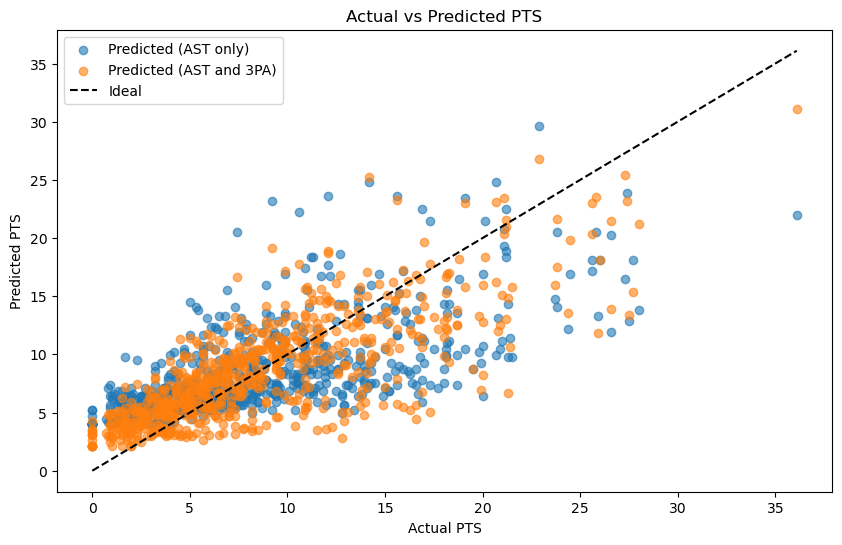

In [22]:
# Compute predicted PTS using AST and 3PA
pred_ast_3pa = model.predict(nba[['AST', '3PA']])

# Visualize actual vs predicted PTS
plt.figure(figsize=(10, 6))
plt.scatter(nba['PTS'], pred_ast_only, label='Predicted (AST only)', alpha=0.6)
plt.scatter(nba['PTS'], pred_ast_3pa, label='Predicted (AST and 3PA)', alpha=0.6)
plt.plot([nba['PTS'].min(), nba['PTS'].max()], [nba['PTS'].min(), nba['PTS'].max()], 'k--', label='Ideal')
plt.xlabel('Actual PTS')
plt.ylabel('Predicted PTS')
plt.title('Actual vs Predicted PTS')
plt.legend()
plt.show()

In [23]:
# Compute RMSE for the model with AST and 3PA
rmse_ast_3pa = rmse(nba['PTS'], pred_ast_3pa)
print(f"RMSE (AST and 3PA model): {rmse_ast_3pa}")

RMSE (AST and 3PA model): 3.6427935954265123


In [24]:
print(f"RMSE (AST only model): {rmse_ast_only}")
print(f"RMSE (AST and 3PA model): {rmse_ast_3pa}")

RMSE (AST only model): 4.291659114148544
RMSE (AST and 3PA model): 3.6427935954265123


We observe that adding `3PA` as an independent variable reduces the RMSE, indicating a better fit and improved model.

### **8.4 ~ Computing R-squared Values**

We compute the R-squared values to quantify the proportion of variance explained by the models.

In [25]:
# Compute R-squared values
r2_ast_only = correlation(pred_ast_only, nba['PTS']) ** 2
r2_ast_3pa = correlation(pred_ast_3pa, nba['PTS']) ** 2
print(f"R-squared (AST only model): {r2_ast_only}")
print(f"R-squared (AST and 3PA model): {r2_ast_3pa}")

R-squared (AST only model): 0.4570055507968592
R-squared (AST and 3PA model): 0.6087862763665709


Including `3PA` improved the \( R^2 \) value, showing that the model explains more variance in the data.